In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib
RANDOM_STATE = 42

In [3]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Rows, columns:", df.shape)
df.head()


Rows, columns: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()
print("\nUnique values per column (sample):")
print(df.nunique().sort_values(ascending=False).head(20))
print("\nTarget distribution:")
print(df['Churn'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop customerID (identifier)
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# Show number of missing values
print("Missing values per column:")
print(df.isna().sum())


Missing values per column:
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [9]:
# For this dataset, missing TotalCharges happens for customers with tenure=0 -> set to 0
if 'TotalCharges' in df.columns:
    num_missing = df['TotalCharges'].isna().sum()
    if num_missing > 0:
        print(f"Filling {num_missing} missing TotalCharges with 0 (tenure zero customers).")
        df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Confirm no missing
print(df.isna().sum().sum(), "total missing values")


Filling 11 missing TotalCharges with 0 (tenure zero customers).
0 total missing values


In [11]:
# Identify categorical vs numerical features
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
# Remove target from cat_cols if present
if 'Churn' in cat_cols:
    cat_cols.remove('Churn')

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [13]:
# For columns with 'No internet service' or 'No phone service' convert them to 'No' for simplicity
replace_cols = []
for col in cat_cols:
    if df[col].dtype == 'object':
        if df[col].str.contains('No internet service').any():
            replace_cols.append(col)
            df[col] = df[col].replace('No internet service', 'No')
        if df[col].str.contains('No phone service').any():
            replace_cols.append(col)
            df[col] = df[col].replace('No phone service', 'No')

print("Columns adjusted:", sorted(set(replace_cols)))


Columns adjusted: ['DeviceProtection', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'StreamingMovies', 'StreamingTV', 'TechSupport']


In [15]:
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})
print("Churn value counts:\n", df['Churn'].value_counts())


Churn value counts:
 Churn
0    5174
1    1869
Name: count, dtype: int64


In [21]:
X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train churn distribution:", y_train.value_counts(normalize=True).to_dict())


Train shape: (5634, 19) Test shape: (1409, 19)
Train churn distribution: {0: 0.7346467873624423, 1: 0.2653532126375577}


In [25]:
import sklearn
print(sklearn.__version__)


1.5.1


In [29]:
# Numeric transformer: impute (mean) + scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical transformer: impute (most frequent) + one-hot encode (drop='first' to avoid collinearity)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

# Build ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'  # drop any remaining columns
)

# For imbalanced pipeline, we'll use imblearn's pipeline during training


In [31]:
print("Train class counts:\n", y_train.value_counts())

Train class counts:
 Churn
0    4139
1    1495
Name: count, dtype: int64


In [33]:

def evaluate_model(model, X_test, y_test, display_plots=True):
    """
    model: trained pipeline (with preprocessing)
    """
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # some models may not have predict_proba (rare here)
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    
    if display_plots:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted'); plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
        plt.plot([0,1],[0,1], linestyle='--')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve')
        plt.legend()
        plt.show()


Logistic Regression trained.
Classification Report:
              precision    recall  f1-score   support

           0     0.9072    0.7179    0.8015      1035
           1     0.5051    0.7968    0.6183       374

    accuracy                         0.7388      1409
   macro avg     0.7061    0.7573    0.7099      1409
weighted avg     0.8005    0.7388    0.7529      1409

ROC AUC: 0.8403523728331913


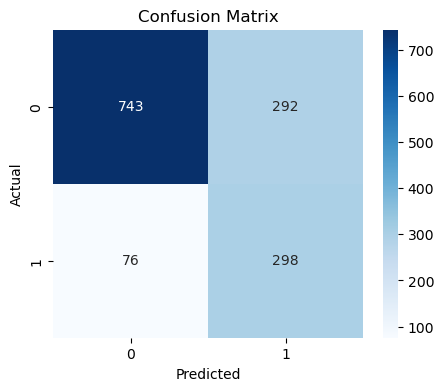

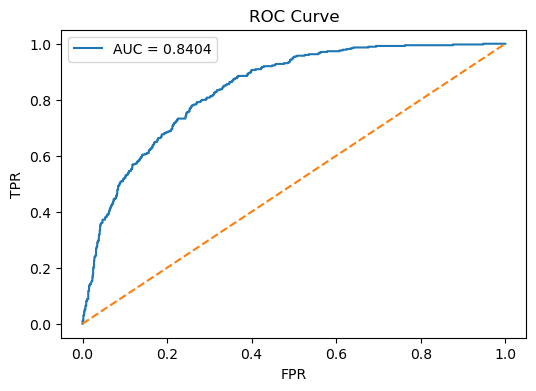

In [35]:
from imblearn.over_sampling import SMOTE

log_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

log_pipeline.fit(X_train, y_train)
print("Logistic Regression trained.")
evaluate_model(log_pipeline, X_test, y_test)


Random Forest trained.
Classification Report:
              precision    recall  f1-score   support

           0     0.8485    0.8493    0.8489      1035
           1     0.5818    0.5802    0.5810       374

    accuracy                         0.7779      1409
   macro avg     0.7151    0.7147    0.7149      1409
weighted avg     0.7777    0.7779    0.7778      1409

ROC AUC: 0.8219535508538066


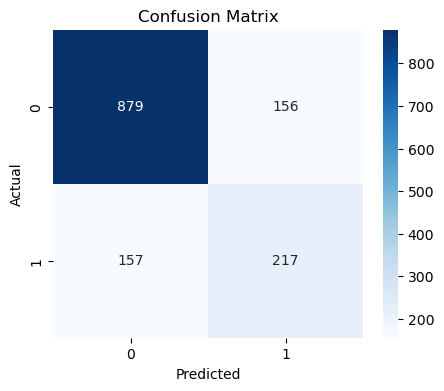

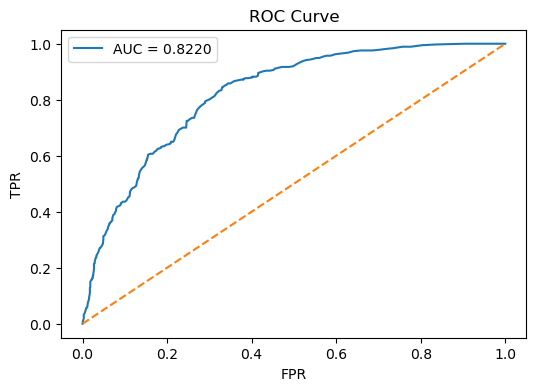

In [37]:
rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)
print("Random Forest trained.")
evaluate_model(rf_pipeline, X_test, y_test)


XGBoost trained.
Classification Report:
              precision    recall  f1-score   support

           0     0.8528    0.8454    0.8491      1035
           1     0.5822    0.5963    0.5892       374

    accuracy                         0.7793      1409
   macro avg     0.7175    0.7208    0.7191      1409
weighted avg     0.7810    0.7793    0.7801      1409

ROC AUC: 0.8176987263943787


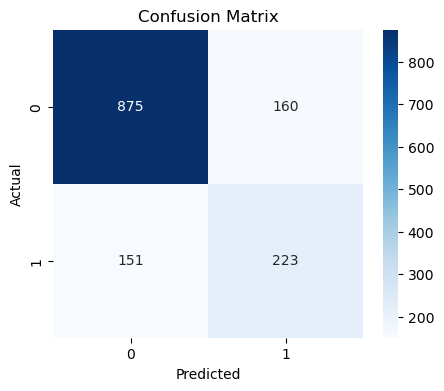

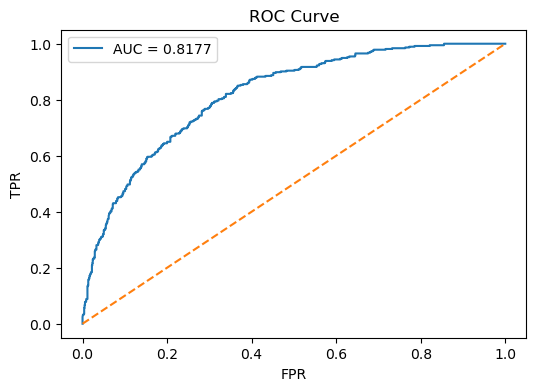

In [39]:
xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE))
])

xgb_pipeline.fit(X_train, y_train)
print("XGBoost trained.")
evaluate_model(xgb_pipeline, X_test, y_test)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__max_depth': 8}
Classification Report:
              precision    recall  f1-score   support

           0     0.8854    0.7836    0.8314      1035
           1     0.5456    0.7193    0.6205       374

    accuracy                         0.7665      1409
   macro avg     0.7155    0.7514    0.7259      1409
weighted avg     0.7952    0.7665    0.7754      1409

ROC AUC: 0.8382055852644088


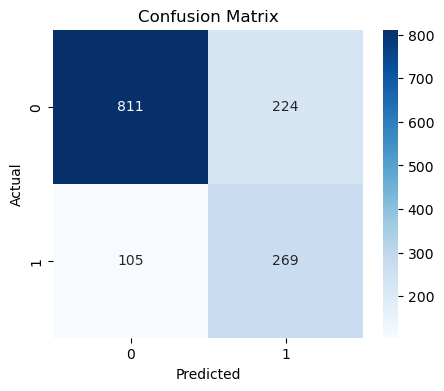

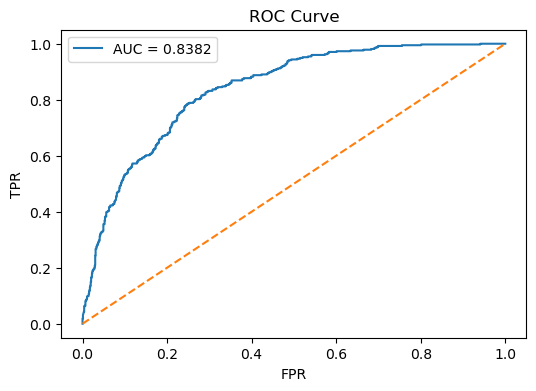

In [41]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [None, 8, 12, 20],
    'clf__min_samples_split': [2, 5, 10]
}

rs = RandomizedSearchCV(rf_pipeline, param_distributions=param_dist, n_iter=6, scoring='roc_auc', cv=3, random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
best_rf = rs.best_estimator_
evaluate_model(best_rf, X_test, y_test)


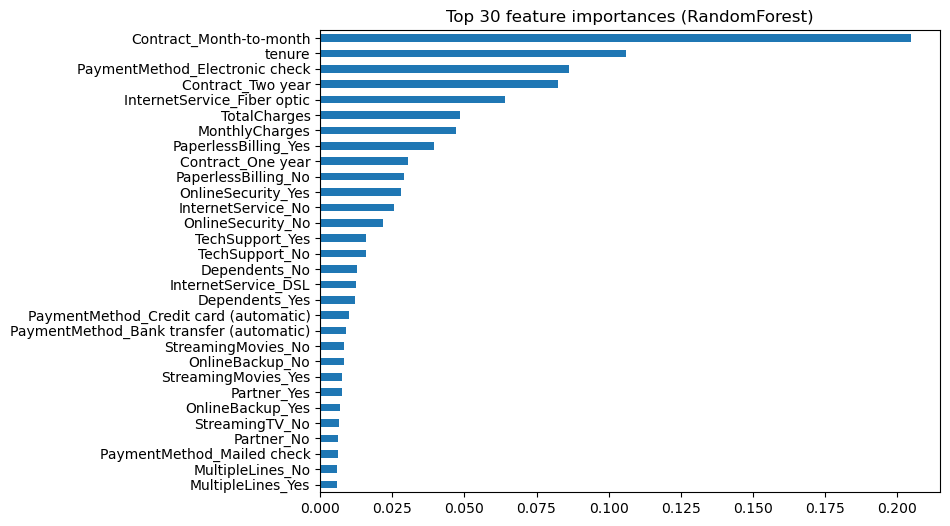

In [43]:
def get_feature_names_from_column_transformer(column_transformer):
    """
    Returns feature names from ColumnTransformer + OneHotEncoder
    """
    output_features = []
    for name, transformer, columns in column_transformer.transformers_:
        if name == 'num':
            output_features += list(columns)
        elif name == 'cat':
            # onehot encoder step
            ohe = transformer.named_steps['onehot']
            ohe_features = ohe.get_feature_names_out(columns)
            output_features += list(ohe_features)
    return output_features

# For a fitted pipeline (best_rf or xgb_pipeline), the preprocessor is at step 'preprocessor'
try:
    feature_names = get_feature_names_from_column_transformer(best_rf.named_steps['preprocessor'])
    importances = best_rf.named_steps['clf'].feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
    plt.figure(figsize=(8,6))
    feat_imp.plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title("Top 30 feature importances (RandomForest)")
    plt.show()
except Exception as e:
    print("Couldn't extract feature importances:", e)


In [45]:
model_to_save = None
try:
    model_to_save = best_rf
except NameError:
    model_to_save = rf_pipeline

joblib.dump(model_to_save, "best_churn_model.pkl")
print("Model saved to best_churn_model.pkl")


Model saved to best_churn_model.pkl


In [47]:
loaded = joblib.load("best_churn_model.pkl")
sample = X_test.iloc[0:1]
print("Sample input:")
display(sample)
pred = loaded.predict(sample)
proba = loaded.predict_proba(sample)[:,1]
print(f"Predicted churn: {pred[0]}, probability: {proba[0]:.4f}")


Sample input:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
437,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8468.2


Predicted churn: 0, probability: 0.0362
